In [131]:
import sys
import pdb
import copy
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [181]:
importlib.reload(putil)
importlib.reload(ces)

spm = 30*24*60*60 # seconds per month

# ----- get counterfatual data
kwargs = {'freq':'monthly', 'return_intersection':False}
u           = putil.get_variable('U', **kwargs)['cfmean']
utendepfd   = putil.get_variable('utendepfd', **kwargs)['cfmean'] * spm
utendresvel = putil.get_variable('utendresvel', **kwargs)['cfmean'] * spm
utendgw     = putil.get_variable('utendgw', **kwargs)['cfmean'] * spm
utenddiff   = -putil.get_variable('utenddiff', **kwargs)['cfmean'] * spm
epfy        = putil.get_variable('epfy', **kwargs)['cfmean']
epfz        = putil.get_variable('epfz', **kwargs)['cfmean']
epdiv       = putil.get_variable('epdiv', **kwargs)['cfmean']
psitem      = putil.get_variable('psitem', **kwargs)['cfmean']
psitem_gp   = putil.get_variable('psitem_gradlat', **kwargs)['cfmean']
psitem_glat = putil.get_variable('psitem_gradp', **kwargs)['cfmean']
trop        = putil.get_variable('TROP_P', **kwargs)['cfmean']

# ----- get 1991 seasonal means
allvars = [u, utendepfd, utendresvel, utendgw, utenddiff, epfy, epfz, psitem, psitem_gp, psitem_glat, trop]
seasons = putil.seasonal_mean(xr.merge(allvars))
seasons = seasons.sel(time=slice(date(1991,6,1), date(1992,5,31)))
seasons = seasons.set_xindex('season')

# ----- get daily counterfatual data
kwargs = {'freq':'10daily', 'return_intersection':True}
u           = putil.get_variable('U', **kwargs)['cfmean']
utendepfd   = putil.get_variable('utendepfd', **kwargs)['cfmean'] * spm
utendresvel = putil.get_variable('utendresvel', **kwargs)['cfmean'] * spm
utenddiff   = putil.get_variable('utenddiff', **kwargs)['cfmean'] * spm
epfy        = putil.get_variable('epfy', **kwargs)['cfmean']
epfz        = putil.get_variable('epfz', **kwargs)['cfmean']
epdiv       = putil.get_variable('epdiv', **kwargs)['cfmean']
psitem      = putil.get_variable('psitem', **kwargs)['cfmean']
psitem_gp   = putil.get_variable('psitem_gradlat', **kwargs)['cfmean']
psitem_glat = putil.get_variable('psitem_gradp', **kwargs)['cfmean']
trop        = putil.get_variable('TROP_P', **kwargs)['cfmean']

In [182]:
#pp = 1 # vortex core
pp = 30 # vortex edge; qbo

#latmin, latmax = 40, 60 # poleward edge of vortex
latmin, latmax = 20, 40 # euqatorward edge of vortex
#latmin, latmax = -5, 5 # tropics

utcolor   = 'k'  #  color for integrated utend
utepcolor = 'indianred'  #  color for integrated utendepfd
utrvcolor = 'dodgerblue'  #  color for integrated utendresvel
utdcolor  = 'gold'  #  color for integrated utenddiff


utepfd = putil.do_slicing(utendepfd, latmin=latmin, latmax=latmax, average=True)
utrv   = putil.do_slicing(utendresvel, latmin=latmin, latmax=latmax, average=True)
utd    = putil.do_slicing(utenddiff, latmin=latmin, latmax=latmax, average=True)
utepfd = utepfd.sel(plev=pp, method='nearest')
utrv   = utrv.sel(plev=pp, method='nearest')
utd    = utd.sel(plev=pp, method='nearest')
if(kwargs['freq'] == 'monthly'):
    #utd  = -utd
    utgw = putil.do_slicing(utendgw, latmin=latmin, latmax=latmax, average=True)
    utgw = utgw.sel(plev=pp, method='nearest')
    ut = utepfd + utrv + utgw + utd
else:
    ut = utepfd + utrv + utd
    
time = putil.to_datetime(ut.time)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, utepfd, '-', color=utepcolor)
ax.plot(time, utrv, '-', color=utrvcolor)
ax.plot(time, utd, '-', color=utdcolor)
ax.plot(time, ut, '-', color=utcolor)
ax.set_xlim([date(1991,6,1), date(1993,6,1)])
ax.axhline(y=0, ls=':', color='k')
putil.season_timeticks(ax, time, 'season')
ax.set_title('[{},{}] N, {} hPa'.format(latmin, latmax, pp))
#plt.show()

Text(0.5, 1.0, '[20,40] N, 30 hPa')

In [183]:
#pp = 1 # vortex core
pp = 30 # vortex edge; qbo
season = 'MAM'

pargs  = {'plev':pp, 'method':'nearest'} 
sargs  = {'season':season, 'lat':slice(-88, 88)}
largs  = {'lat':slice(-89, 89)}
u      = seasons['U'].sel(**pargs).sel(**sargs)
utepfd = seasons['utendepfd'].sel(**pargs).sel(**sargs)
utrv   = seasons['utendresvel'].sel(**pargs).sel(**sargs)
utd    = seasons['utenddiff'].sel(**pargs).sel(**sargs)
utgw   = seasons['utendgw'].sel(**pargs).sel(**sargs)
ut     = utepfd + utrv + utgw + utd
lat = ut.lat

fig = plt.figure()
ax = fig.add_subplot(111)

# plot U
ax.plot(lat, u, '--', lw=4, color='limegreen', alpha=0.75)

# plot tendencies
lw=2
ax.plot(lat, utepfd, lw=lw, color=utepcolor)
ax.plot(lat, utrv, lw=lw, color=utrvcolor)
#ax.plot(lat, utgw, '-', color='orange')
#ax.plot(lat, utd, '-y')
ax.plot(lat, utd+utgw, lw=lw, color=utdcolor)
ax.plot(lat, ut, lw=lw, color=utcolor)

# format
putil.format_lataxis(ax)
ax.set_xlim([-87, 87])
ax.set_title('{}, {} hPa'.format(season, pp))
ylim = ax.get_ylim()
#ax.axhline(y=0, ls=':', color='k')
ax.fill_between(lat, y1=u*0, y2=u*0+ylim[0], color='k', alpha=0.07)
ax.set_ylim(ylim)

#plt.show()

(-34.5975858496583, 36.14060129860173)

In [208]:
importlib.reload(putil)
importlib.reload(ces)

Fx, Fy = None, None

def make_plot(pp, epvscale=1e15, rvvscale=40, dslat=1, dsp=1, logepvec=False, logrvvec=True):
    
    # --- check passed pressure levels
    try:
        npp = len(pp)
    except TypeError:
        pp = [pp]
        npp = len(pp)
    
    # --- plotting settings
    pbuff            = 20           # tropopause buffer if remove_trop_vectors=True
    troplw, tropcolor, tropalph = 5, 'w', 0.75  # tropopause linewidth, color
    cbheight = 0.77          # colorbar height
    utcolor   = 'k'  #  color for utend
    utepcolor = 'indianred'  #  color for utendepfd
    utrvcolor = 'dodgerblue'  #  color for utendresvel
    utdcolor  = 'silver'  #  color for utenddiff
    utgwcolor  = 'gold'  #  color for utenddiff
    tlw = 1.5 # linewidth for tendencies 
    ucmap = 'RdYlBu_r'
    latlim = [-88, 88]
    latticks = [-60, -30, 0, 30, 60]
    
    # --- vector field settings
    vw, vhw, vhl      = 0.009,2.4,4   # vector arrow width, head width, and head length to quiver()
    epvcolor          = 'k'          # EP flux vector arrow color
    rvvcolor          = 'royalblue'          # residual velocity vector arrow color
    vecolor           = 'w'          # vector outline color
    vlw               = 0.5         # vector outline linewidth
    interp_vectors = True
    remove_trop_epvectors = False
    remove_trop_rvvectors = True
    
    # --- contour settings
    ulevels = np.arange(-40, 81, 10)
    
    # --- make axes
    fig = plt.figure(figsize=(15, (9/17)*15))
    gsm = gridspec.GridSpec(2, 1, height_ratios=[1,1], figure=fig, hspace=0.3)
    gs  = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gsm[0], wspace=0.17)
    gst = gridspec.GridSpecFromSubplotSpec(npp, 4, subplot_spec=gsm[1], hspace=0, wspace=0.17)
    
    for season in ['JJA', 'SON', 'DJF', 'MAM']:
            
        # --- get axes
        axcol = {'JJA':0,'SON':1,'DJF':2,'MAM':3}[season]
        uax   = fig.add_subplot(gs[0, axcol])
        tax   = [fig.add_subplot(gst[i, axcol]) for i in range(npp)]
        
        # ------------- plot U
        norm   = putil.get_cmap_norm(ulevels, 'twoslope')
        u = seasons['U'].sel(season=season)
        cvc = uax.contourf(u.lat, u.plev, u.T, levels=ulevels, cmap=ucmap, norm=norm, extend='both')
        uax.contour(u.lat, u.plev, u.T, levels=ulevels, linestyles='-', colors='w', linewidths=0.66, alpha=0.75)
        # --- plot tropopause
        trop = seasons['TROP_P'].sel(season=season)
        uax.plot(trop.lat, trop/100, color=tropcolor, lw=troplw, alpha=tropalph)
        # --- format
        uax.set_ylim([0.3, 1000])
        uax.set_xlim(latlim)
        putil.format_paxis(uax)
        putil.format_lataxis(uax, ticks=latticks)
        
        # --- overlay EP flux vector field
        epfy_, epfz_ = seasons['epfy'].sel(season=season),  seasons['epfz'].sel(season=season)
        if(interp_vectors):
            # interpolate the vector field to a uniform grid in lat-log(p)
            epfy_, epfz_ = putil.regrid_vectors_latp(epfy_, epfz_)
        if(remove_trop_epvectors):
            # remove vectors in the troposphere so that they don't influence the length scaling
            epfy_ = putil.remove_troposphere(epfy_, trop, buffer=pbuff)
            epfz_ = putil.remove_troposphere(epfz_, trop, buffer=pbuff)
        # finally do EP flux vector scaling (this MUST be done after any changes to the fig size/shape)
        Fx, Fy = putil.scale_EP_flux_vectors(fig, uax, epfy_, epfz_, dslat=dslat, dsp=dsp,log_vectors=logepvec,
                                             dsplog=False, interp_lat=False, interp_plev=False)
        # plot scaled vector field
        LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
        # threshold nans so that dots arent plotting by quiver
        Fx = Fx.where(np.abs(Fx) > 2e13)
        Fy = Fy.where(np.abs(Fy) > 2e13)
        qvep = uax.quiver(LAT, PLEV, Fx.T, Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9,
                          scale=epvscale, scale_units='inches', color=epvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
        qvep.set_rasterized(True)
        
        
       # ---- plot residual circulation streamfunction contours
        psicolor='grey'
        psitem = seasons['psitem'].sel(season=season)
        lev = np.array([10**1.5, 1e2, 10**2.5])
        lev = np.array([30, 100, 500])
        lev = np.hstack([-lev[::-1], lev])
        psilw = 1.2
        uax.contour(u.lat, u.plev, psitem.T/1e7, levels=lev, colors=psicolor, linewidths=psilw)
        uax.contour(u.lat, u.plev, psitem.T/1e7, levels=[0], colors=psicolor, linewidths=psilw*2)

        
        
        # ------------- plot tendencies at specified pressure levels
        for i in range(npp):
            # --- get data
            pargs  = {'plev':pp[i], 'method':'nearest'} 
            sargs  = {'season':season, 'lat':slice(-88, 88)}
            uu     = seasons['U'].sel(**pargs).sel(**sargs)
            utepfd = seasons['utendepfd'].sel(**pargs).sel(**sargs)
            utrv   = seasons['utendresvel'].sel(**pargs).sel(**sargs)
            utd    = seasons['utenddiff'].sel(**pargs).sel(**sargs)
            utgw   = seasons['utendgw'].sel(**pargs).sel(**sargs)
            ut     = utepfd + utrv + utgw + utd
            
            # --- plot
            # plot U
            tax[i].plot(lat, uu, '--', lw=tlw*2, color='limegreen', alpha=0.75)
            # plot tendencies
            tax[i].plot(lat, utepfd, lw=tlw, color=utepcolor)
            tax[i].plot(lat, utrv, lw=tlw, color=utrvcolor)
            tax[i].plot(lat, utgw, lw=tlw, color=utgwcolor)
            tax[i].plot(lat, utd, lw=tlw/1.2, color=utdcolor)
            #tax[i].plot(lat, utd+utgw, lw=tlw, color=utdcolor)
            tax[i].plot(lat, ut, lw=tlw, color=utcolor)
            
            # --- color negative region
            ylim = tax[i].get_ylim()
            tax[i].fill_between(lat, y1=uu*0, y2=uu*0+ylim[0], color='k', alpha=0.07)
            
            # --- configure ticks...
            rylim = max([abs(round(ylim[0]*0.8, -1)), abs(round(ylim[1]*0.8, -1))])
            #if(rylim > 30):
            #    if(rylim%20 != 0): rylim = rylim-10
            if(rylim > 90): rylim -= rylim-90 
            ticks = [-rylim, -rylim/2, 0, rylim/2, rylim]
            tax[i].yaxis.set_ticks(ticks)
            tax[i].set_ylim(ylim)
            

        # ---- format u axes
        if(season in ['JJA','SON']): yearstr=1991
        else:                        yearstr=1992
        if(axcol==0):   y = 'left'
        #elif(axcol==3): y = 'right'
        else:           y = None
        putil.format_ticks(uax, y=y)
        
        if(axcol==0):
            uax.set_ylabel('pressure [hPa]')
        uax.set_title('{} {}'.format(season, yearstr), loc='center', pad=8, fontsize=18)
        
        letter = ['(a)','(b)','(c)','(d)'][axcol]
        uax.annotate(letter, xy=(-0.03, 1.03), xycoords="axes fraction", fontsize=15)#, weight = 'bold')
        letter = ['(d)','(e)','(f)','(g)'][axcol]
        tax[0].annotate(letter, xy=(-0.03, 1.06), xycoords="axes fraction", fontsize=15)#, weight = 'bold')
        
        # ---- format tendency axes
        for i in range(npp):
            putil.format_lataxis(tax[i], ticks=latticks)
            tax[i].set_xlim(latlim)
            if(i == npp-1): labelbottom=True
            else:           labelbottom=False
            targs = {'top':True,'bottom':True,'left':True,'right':False,'which':'both',
                     'labeltop':False,'labelbottom':labelbottom,'labelleft':True,'labelright':False}
            tax[i].tick_params(**targs)
            
            if(i==0 and axcol==0):
                tax[i].set_ylabel('$\\overline{u}$ tendency [m s$^{-1}$ month$^{-1}$]'+' '*23)
                
                # --- legend
                # dummy plots
                tax[i].plot([0], [0], lw=tlw, color=utepcolor, label='EPFD')# label='$\\nabla\\cdot\\mathbf{F}$')
                tax[i].plot([0], [0], lw=tlw, color=utrvcolor, label='residual circulation')#label='($v^*$, $w^*$)')
                tax[i].plot([0], [0], lw=tlw, color=utgwcolor, label='GW')
                tax[i].plot([0], [0], lw=tlw/1.2, color=utdcolor, label='diffusion')
                #tax[i].plot([0], [0], lw=tlw, color=utdcolor, label='parameterized')#label='$\\overline{X}$')
                tax[i].plot([0], [0], lw=tlw, color=utcolor, label='total')#label='$\\partial\\overline{u}/\\partial{t}$')
                tax[i].plot([0], [0], '--', lw=tlw*2, color='limegreen', alpha=0.75, label='$\\overline{u}$ [m s$^{-1}$]')
                leg = tax[i].legend(bbox_to_anchor=(2.22, -1.33), frameon=False, fancybox=False, edgecolor='k', ncol=6, columnspacing=1, handlelength=2, loc='center', fontsize=12)
                leg.get_frame().set_linewidth(0.66)
            
            if(i == 1 and axcol == 0):
                tax[i].plot([0], [0], '-', lw=psilw, color=psicolor, label='residual circulation streamfunction [$10^7$ kg s$^{-1}$]')
                #tax[i].quiverkey(qvep, X=2.15, Y=-0.19, U=epvscale/2, label='EP flux', labelpos='E', fontproperties={'size':13})
                tax[i].scatter([], [], marker=r'$\longrightarrow$', c="black", s=400, label="EP flux")
                leg = tax[i].legend(bbox_to_anchor=(2.22, 2.29), frameon=False, fancybox=False, edgecolor='k', ncol=6, columnspacing=1, handlelength=2, loc='center', fontsize=12)
                leg.get_frame().set_linewidth(0.66)
            
            if(axcol==3):
                tax[i].yaxis.set_label_position('right')
                tax[i].set_ylabel('{} hPa'.format(pp[i]), bbox=dict(facecolor='white', edgecolor='black'), fontsize=18, labelpad=17)
                
        # --- colorbar
        if(axcol == 3):
            # --- colorbar
            cbpos = [0.913, 0.5445, 0.02, 0.336]
            cblab = '$\\overline{u}$ [m/s]'
            cb = fig.colorbar(cvc, cax=fig.add_axes(cbpos), orientation='vertical', location='right', format=FuncFormatter(putil.cbarfmt), extendrect=True)
            cb.set_label(cblab)
            cb.set_ticks(cvc.levels)
            

    plt.savefig('figs/counterfactual_seasonal_budget.pdf', dpi=250, bbox_inches='tight')
    plt.show()

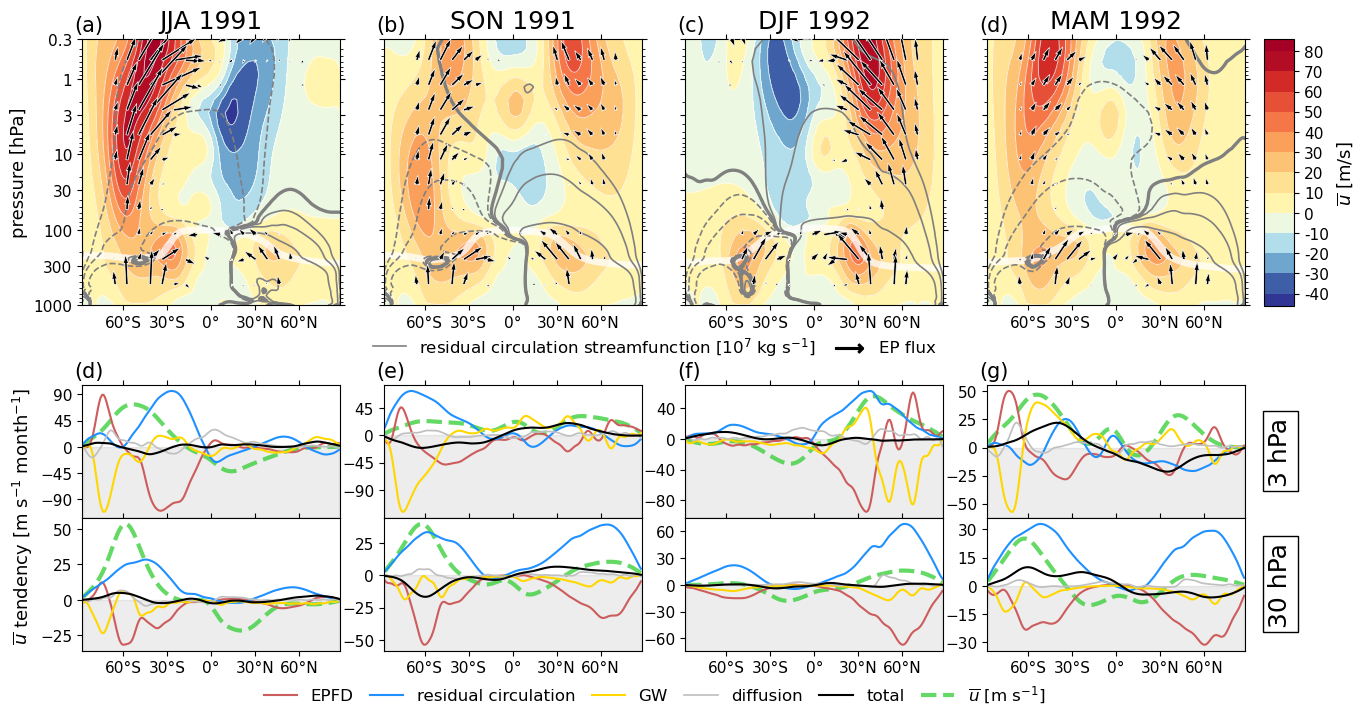

In [209]:
make_plot([3, 30], epvscale=2e15, rvvscale=40, dslat=8, dsp=6)